# PART 1
*Aggregate login counts based on 15 min intervals

*Visualize + Describe resulting time series of login counts

*Report underlying patterns of the demand, important features of the demand, and any data issues


In [21]:
import json

with open('logins.json') as l:
    f = json.load(l)

In [22]:
with open('ultimate_data_challenge.json') as p:
    q = json.load(p)

In [23]:
import pandas as pd

df_info = pd.DataFrame(q)
df_time = pd.DataFrame(f)

In [24]:
df_time.head()

login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21

In [86]:
print(df_time.isnull().sum())

login_time    0
Count         0
dtype: int64


Well this is a good look! 

In [27]:
df_time.dtypes

login_time    object
dtype: object

In [29]:
from datetime import datetime

df_time.login_time = pd.to_datetime(df_time.login_time)

In [31]:
df_time.dtypes

login_time    datetime64[ns]
dtype: object

In [44]:
df_time['Count'] = 1

In [51]:
df_time

login_time  Count
0     1970-01-01 20:13:18      1
1     1970-01-01 20:16:10      1
2     1970-01-01 20:16:37      1
3     1970-01-01 20:16:36      1
4     1970-01-01 20:26:21      1
...                   ...    ...
93137 1970-04-13 18:50:19      1
93138 1970-04-13 18:43:56      1
93139 1970-04-13 18:54:02      1
93140 1970-04-13 18:57:38      1
93141 1970-04-13 18:54:23      1

[93142 rows x 2 columns]

In [52]:
counts= df_time.resample('15T', on='login_time').sum().reset_index()

In [53]:
counts.columns

Index(['login_time', 'Count'], dtype='object')

In [59]:
counts.size

19576

(array([  0.,  14.,  31.,  45.,  59.,  73.,  90., 104.]),
 [Text(0.0, 0, '1970-01-01'),
  Text(14.0, 0, '1970-01-15'),
  Text(31.0, 0, '1970-02-01'),
  Text(45.0, 0, '1970-02-15'),
  Text(59.0, 0, '1970-03-01'),
  Text(73.0, 0, '1970-03-15'),
  Text(90.0, 0, '1970-04-01'),
  Text(104.0, 0, '1970-04-15')])

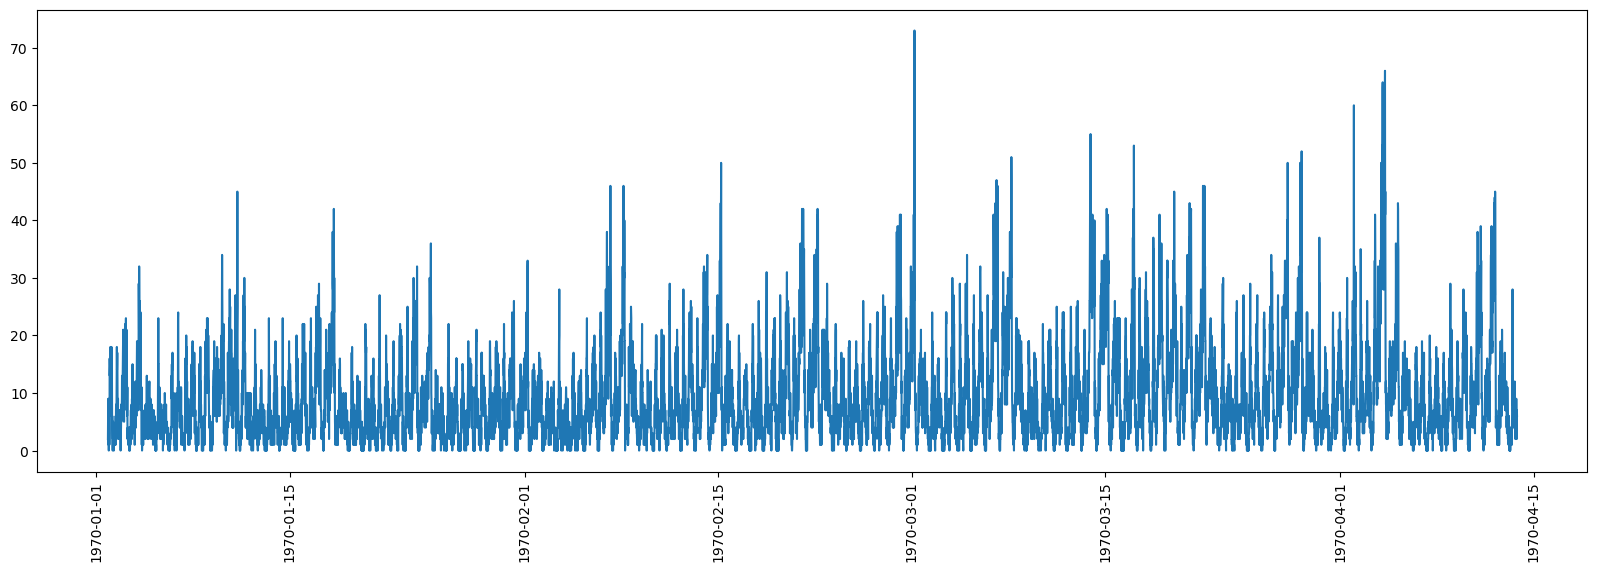

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.plot(counts['login_time'], counts['Count'])
plt.xticks(rotation=90)

In [67]:
df_times2 = df_time.drop(columns='Count')

In [69]:
df_times2.set_index('login_time', inplace=True)

In [70]:
log_counts = df_times2.resample('15T').size()

<Axes: xlabel='login_time'>

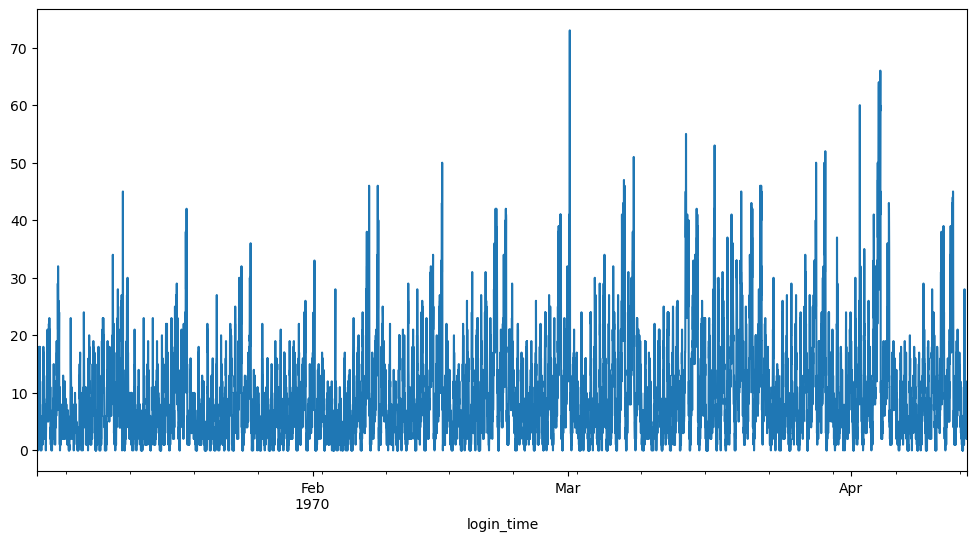

In [72]:
plt.figure(figsize=(12,6))
log_counts.plot()

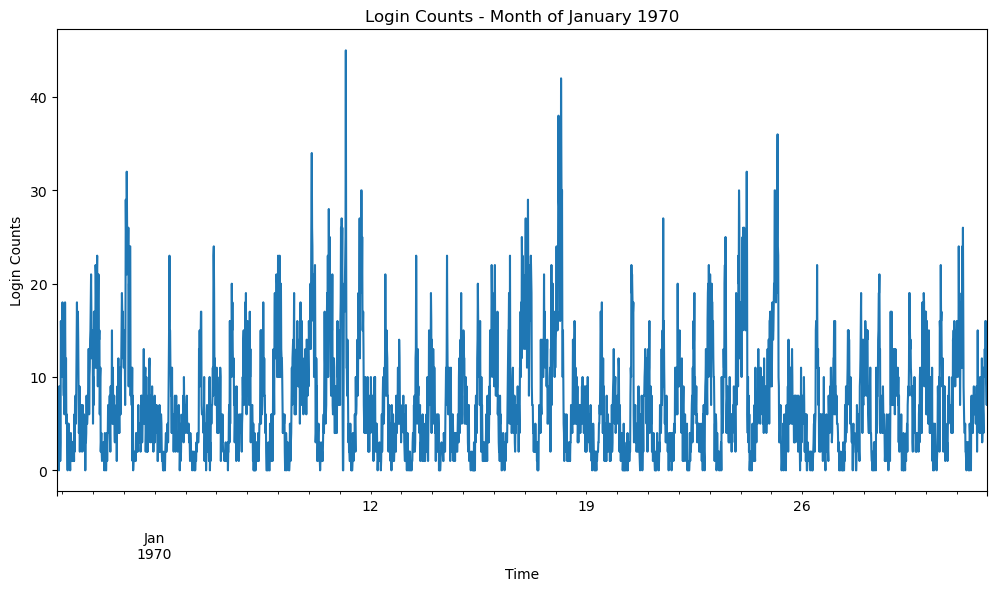

In [75]:

plt.figure(figsize=(12, 6))
log_counts['1970-01-01':'1970-01-31'].plot()
plt.title('Login Counts - Month of January 1970')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.show()

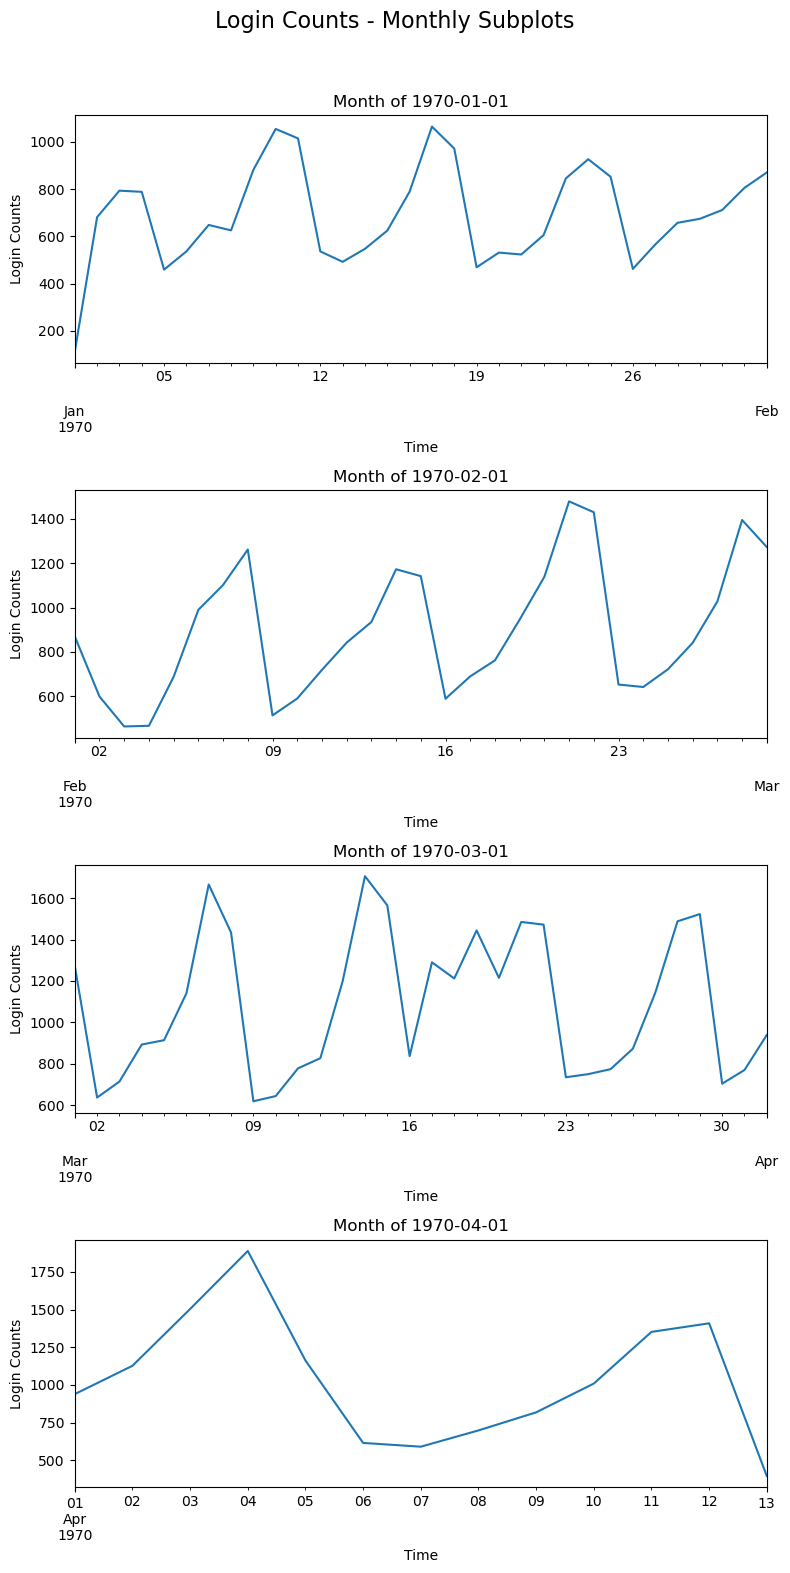

In [79]:
daily_log = log_counts.resample('D').sum()

months = ['1970-01', '1970-02', '1970-03', '1970-04']


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 16))
fig.suptitle('Login Counts - Monthly Subplots', fontsize=16)

for i, month in enumerate(months):
    # Extract data for the specific month
    start_date = month + '-01'
    end_date = (pd.to_datetime(start_date) + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    monthly_data = daily_log[start_date:end_date]
    
    # Plot the subplot
    ax = axes[i]
    monthly_data.plot(ax=ax)
    ax.set_title(f'Month of {start_date}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Login Counts')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

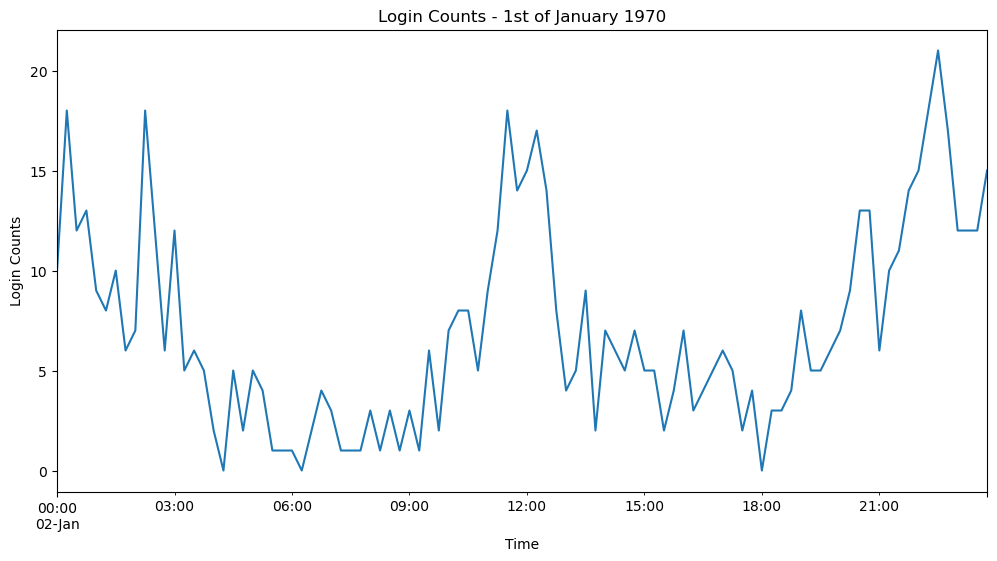

In [81]:

plt.figure(figsize=(12, 6))
log_counts['1970-01-02':'1970-01-02'].plot()
plt.title('Login Counts - 1st of January 1970')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.show()

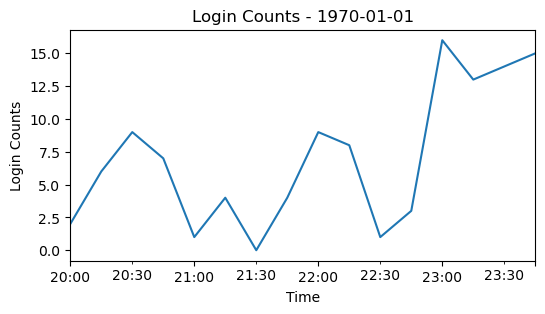

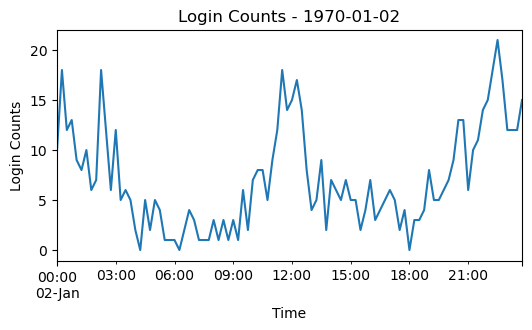

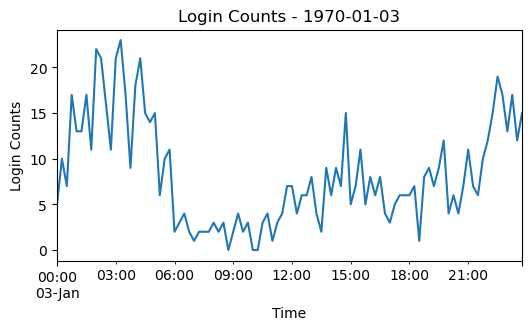

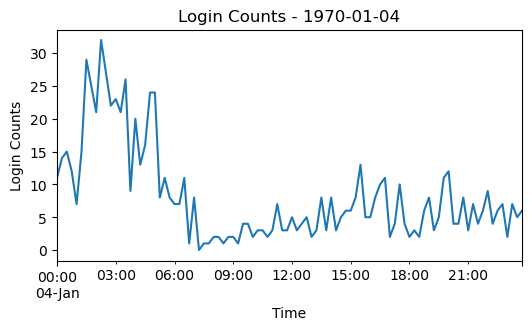

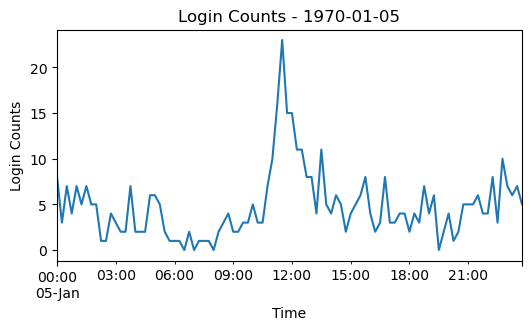

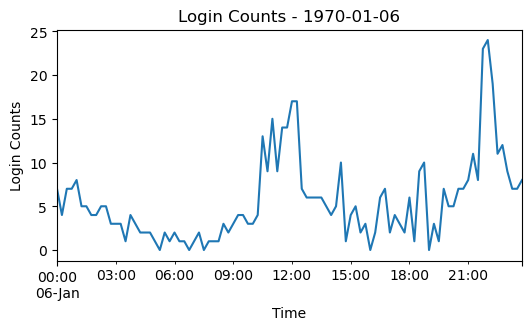

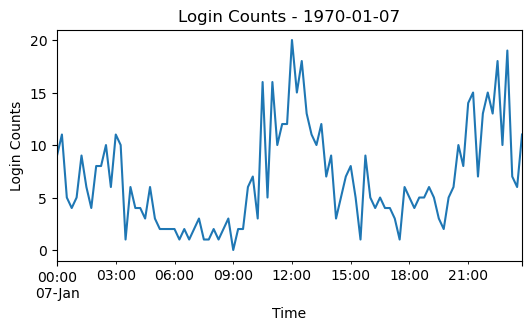

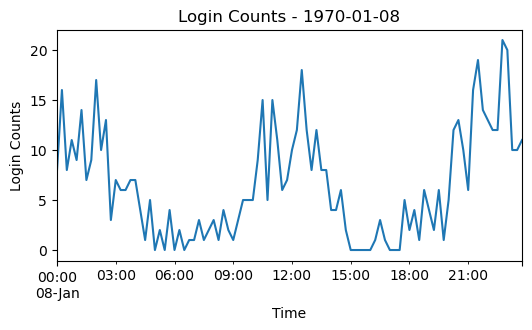

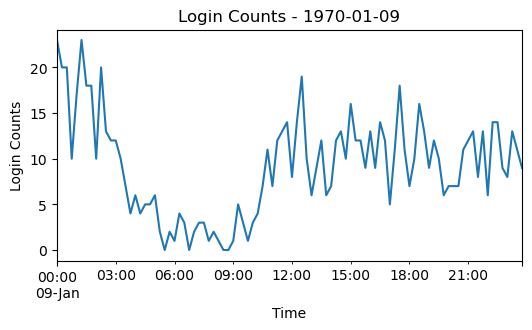

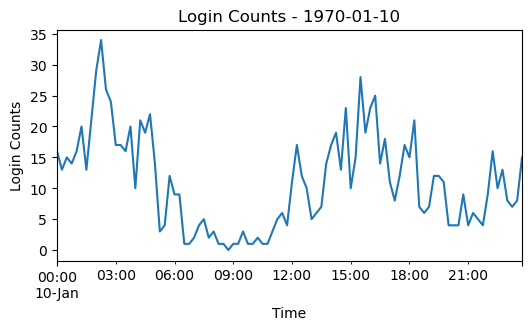

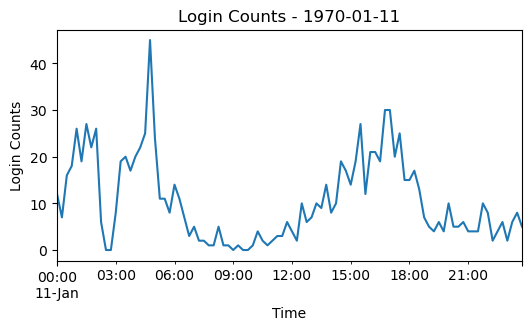

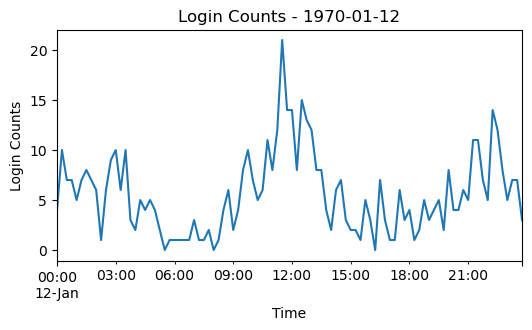

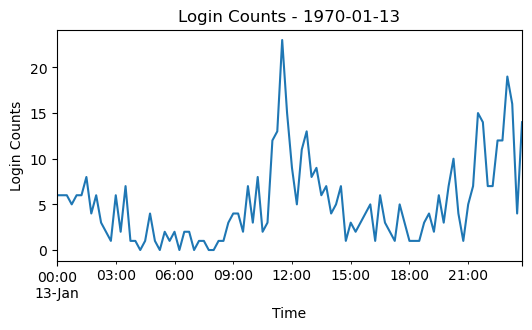

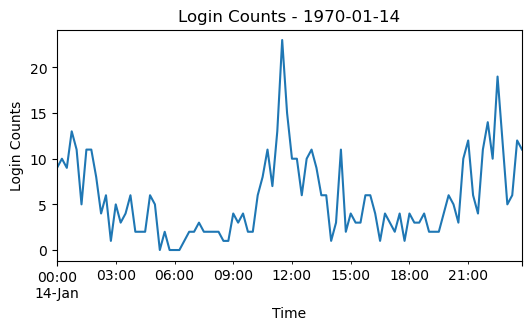

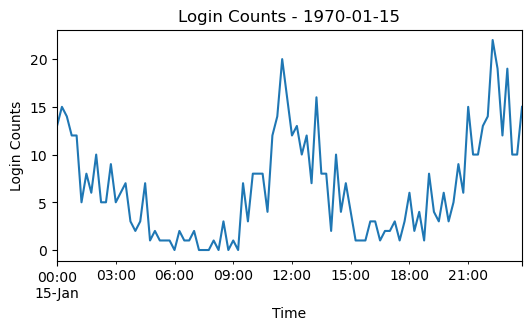

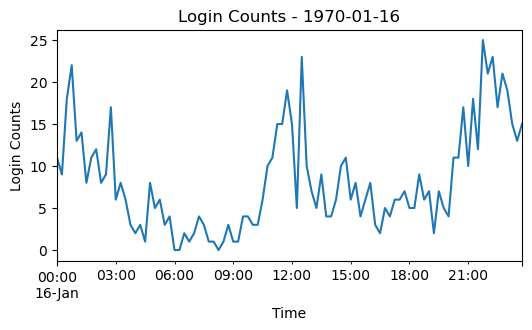

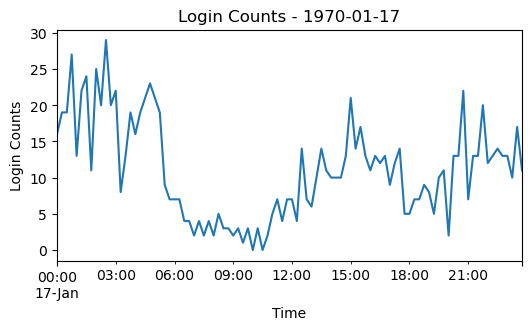

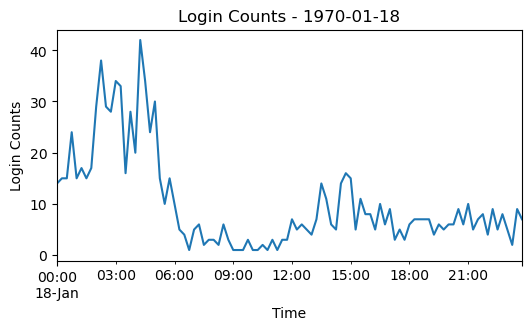

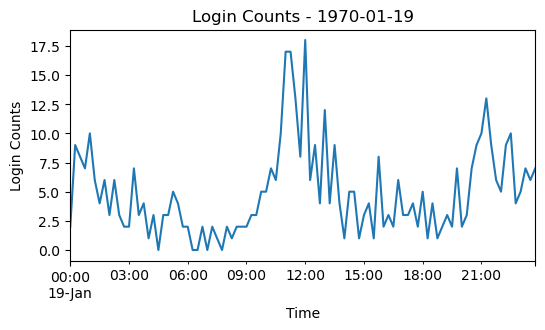

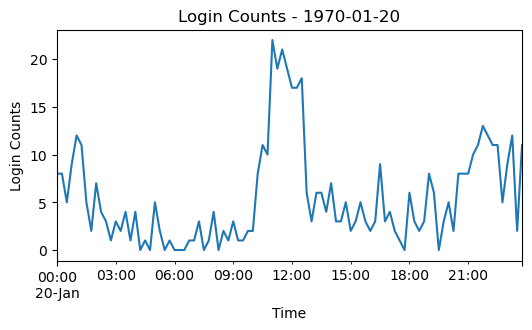

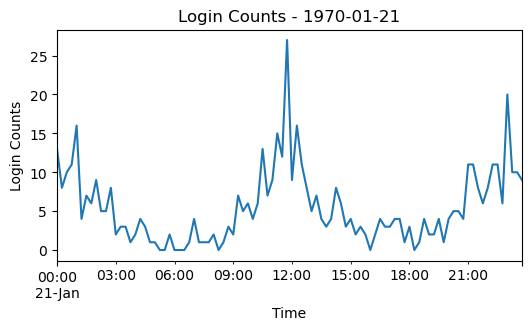

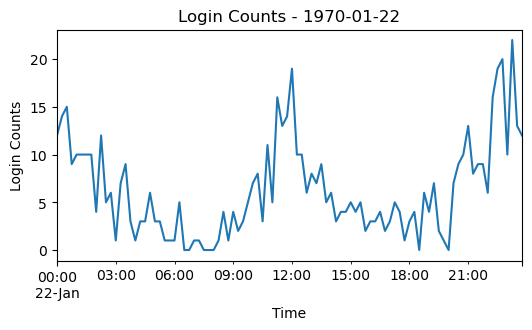

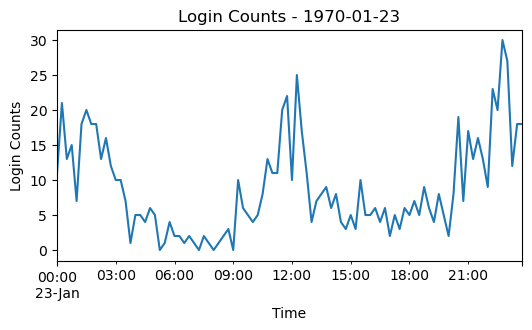

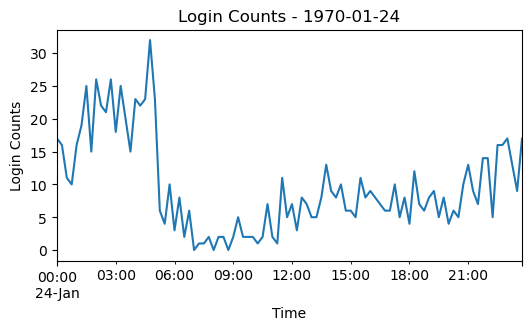

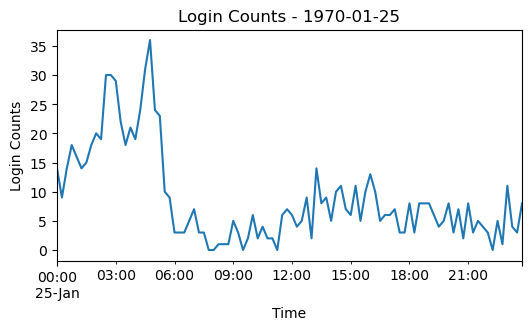

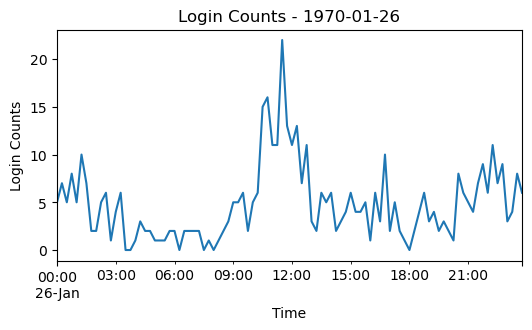

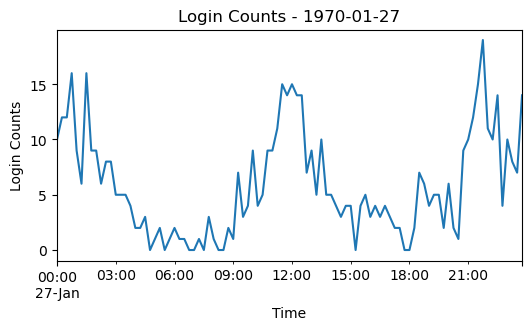

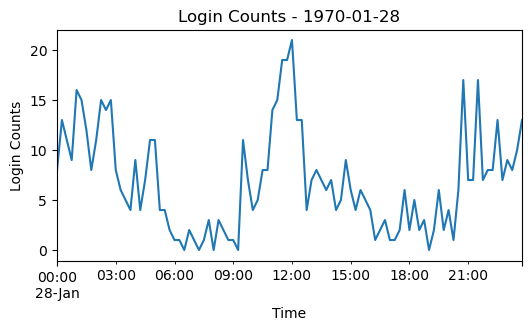

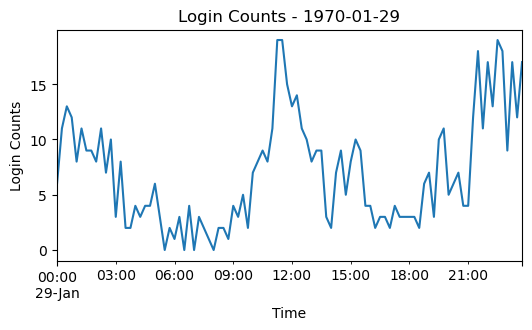

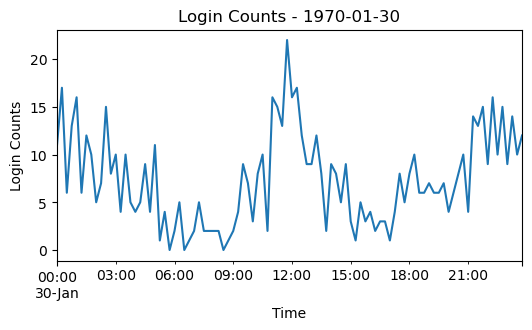

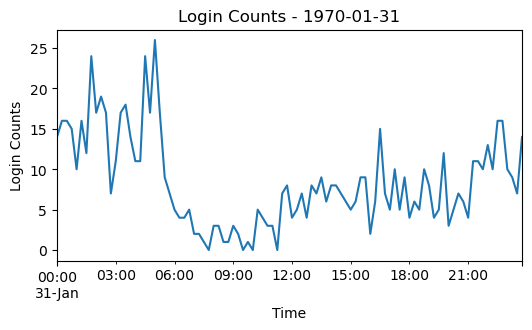

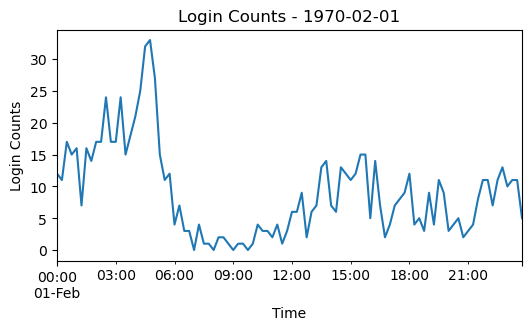

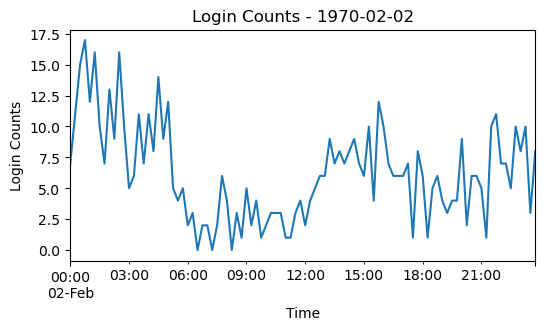

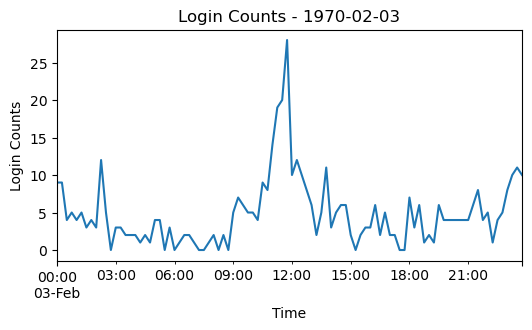

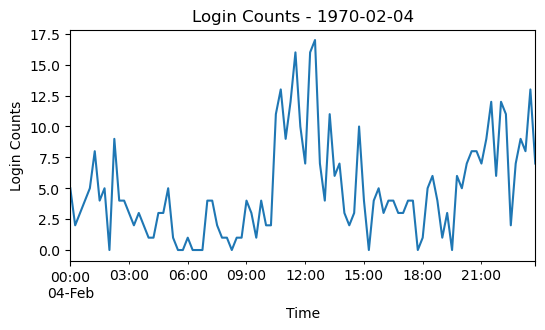

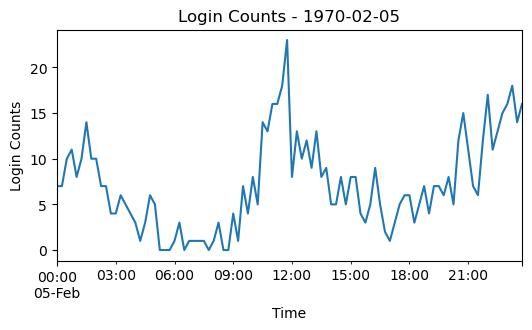

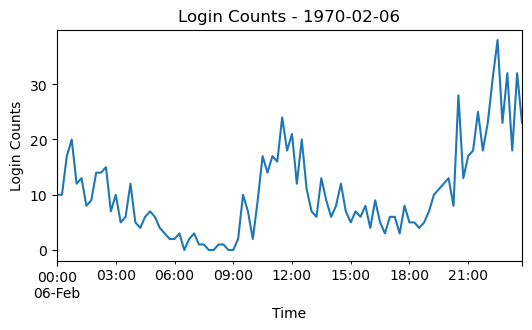

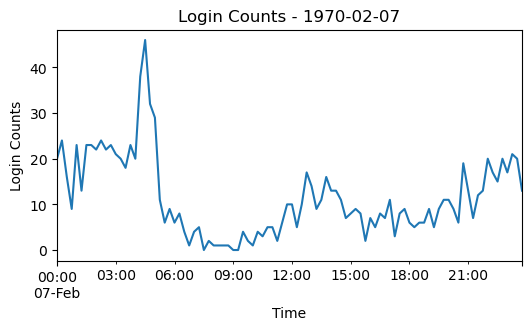

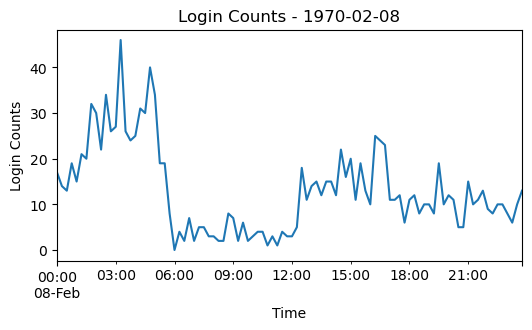

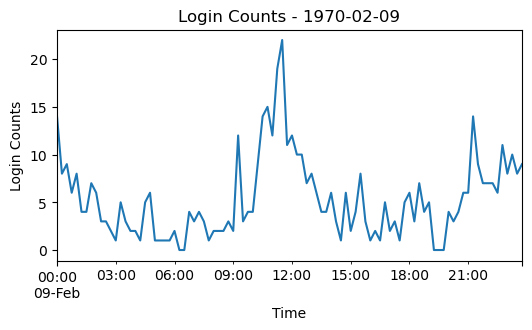

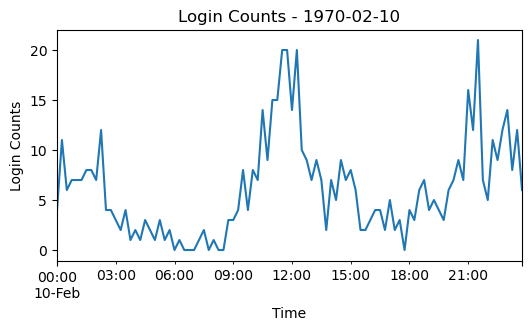

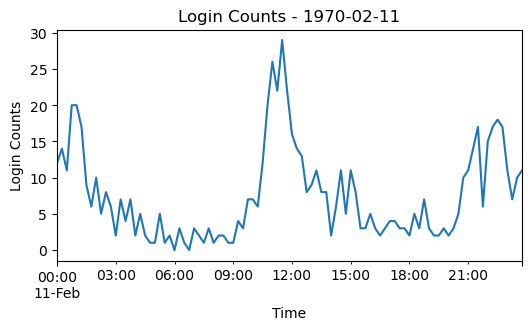

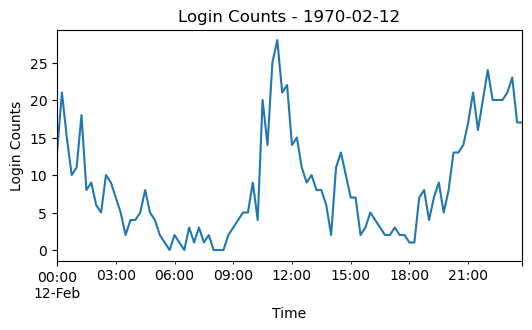

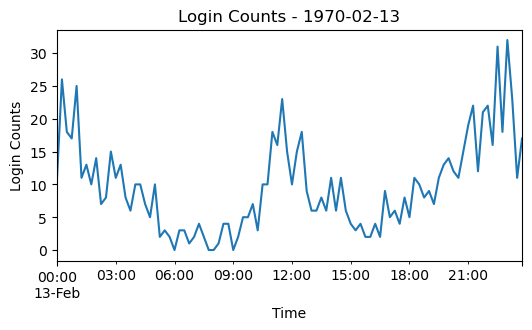

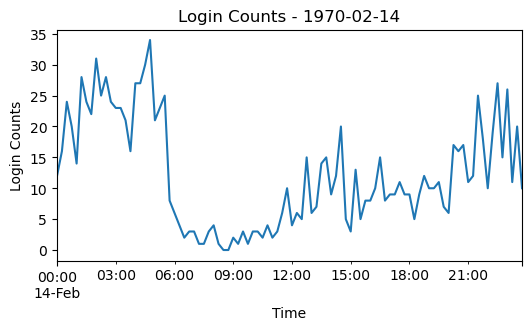

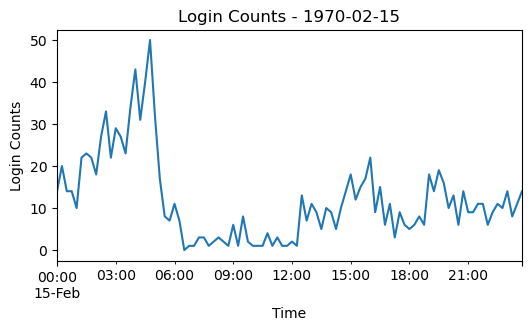

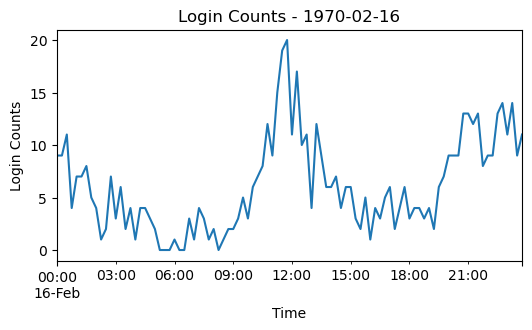

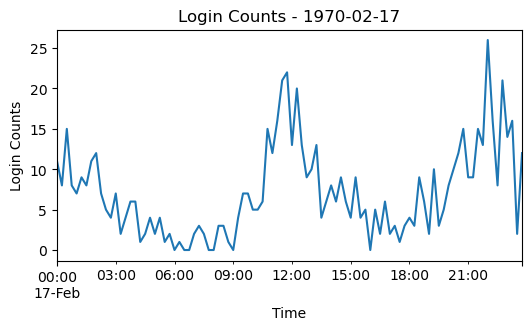

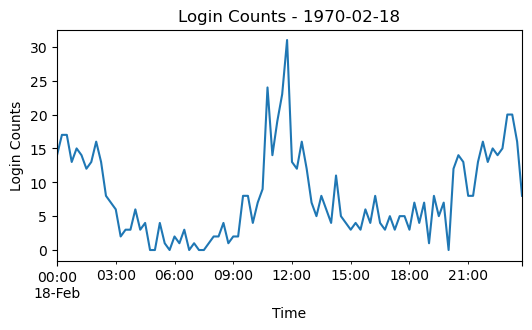

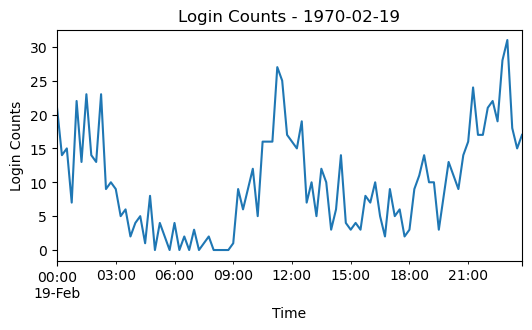

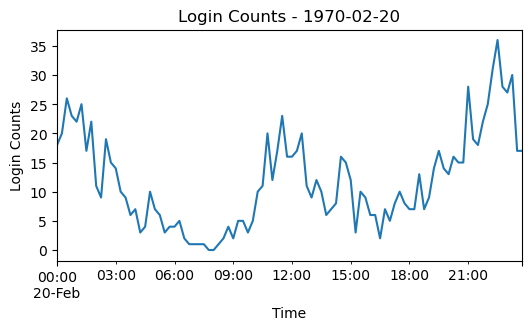

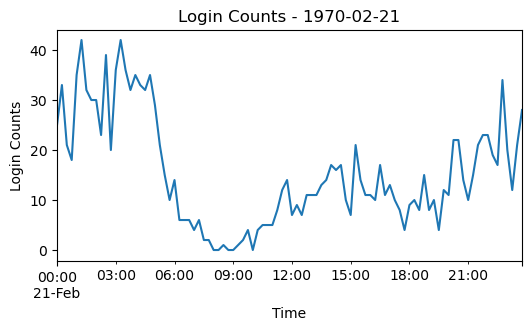

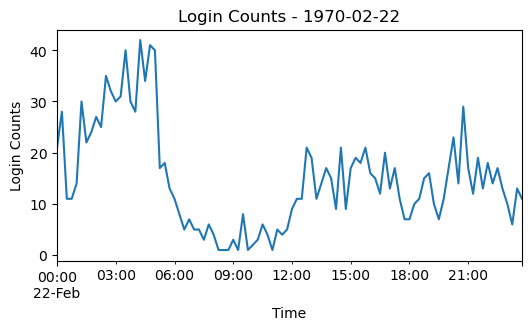

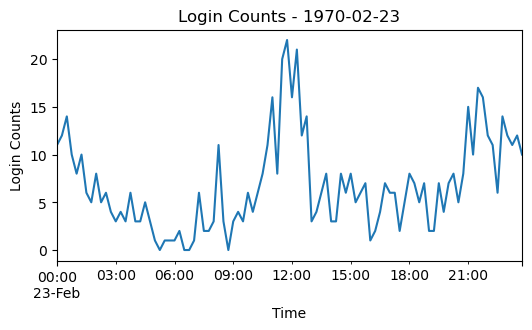

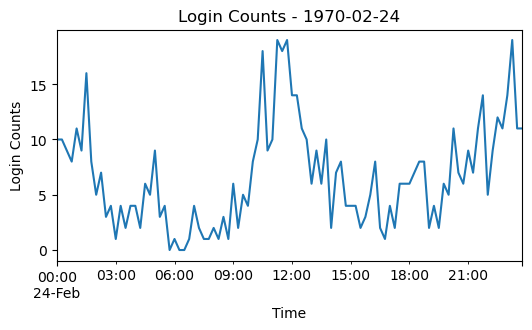

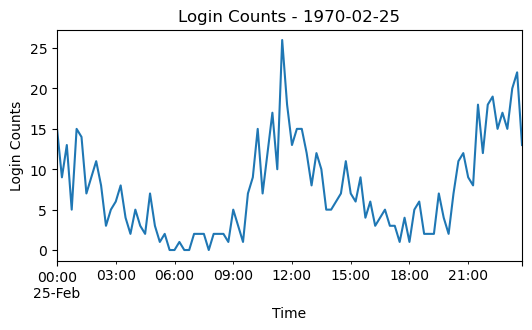

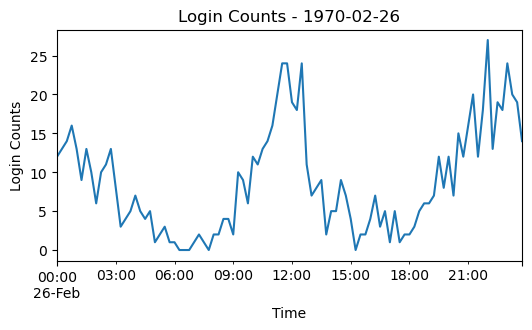

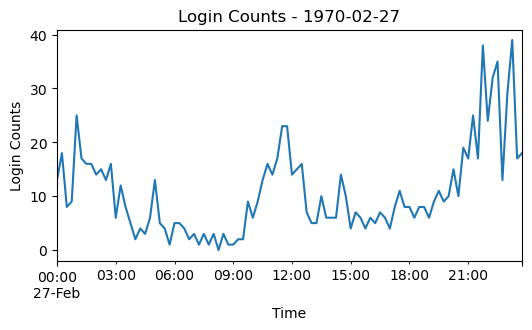

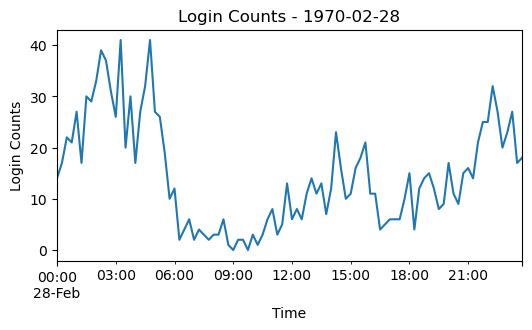

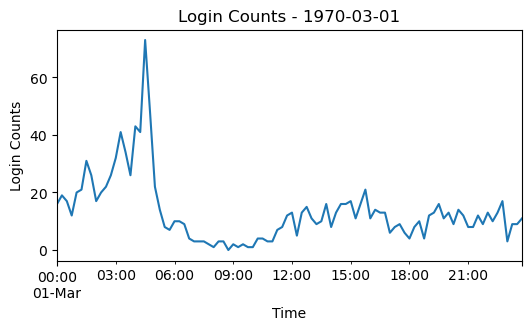

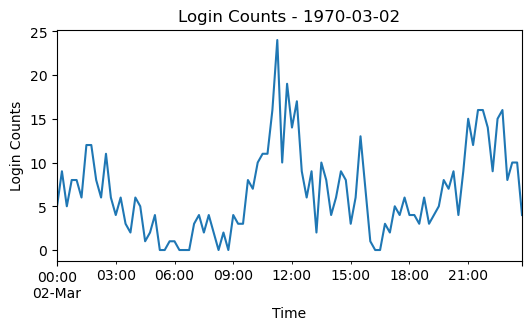

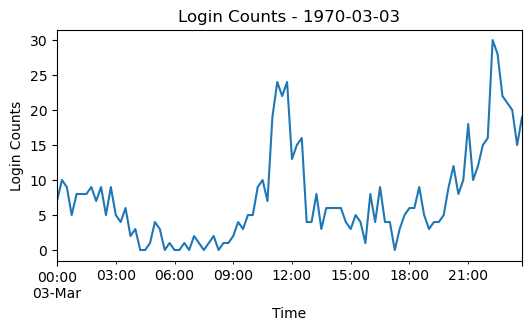

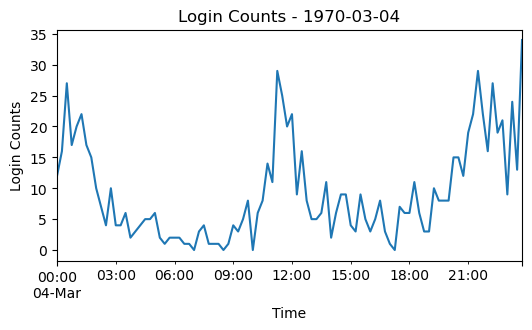

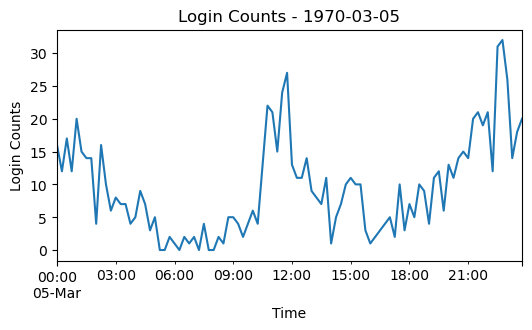

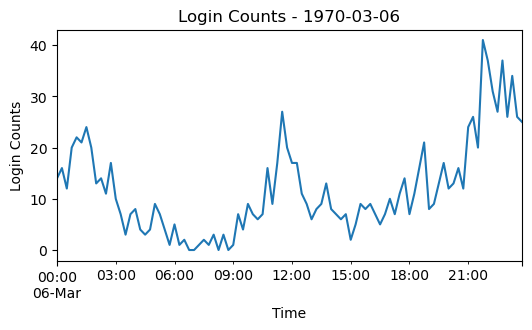

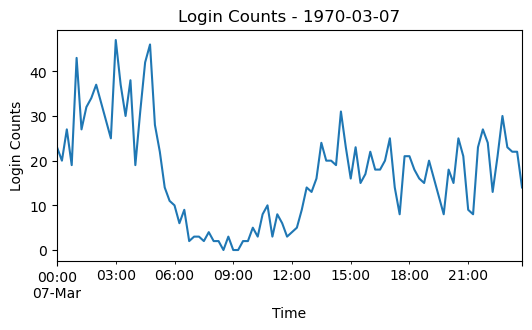

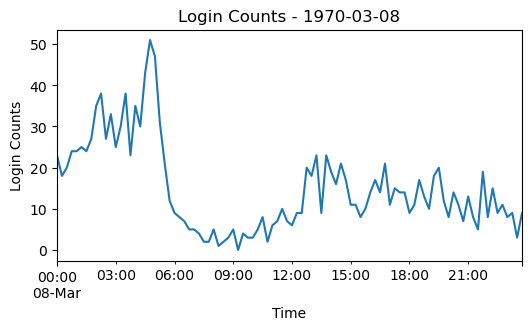

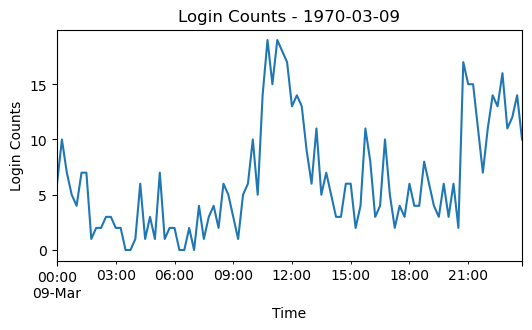

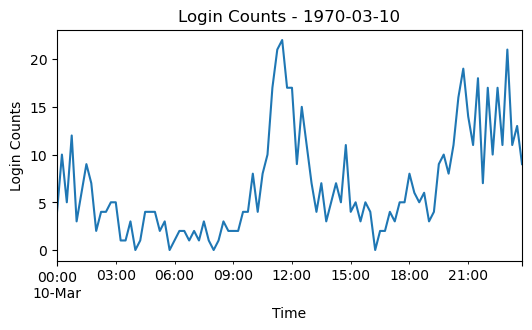

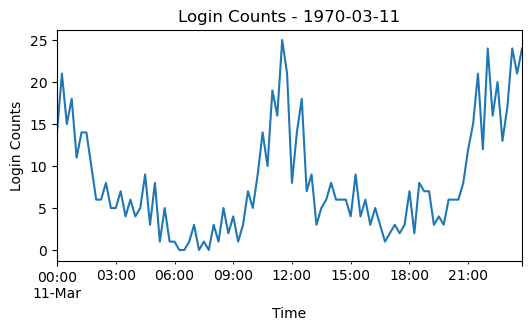

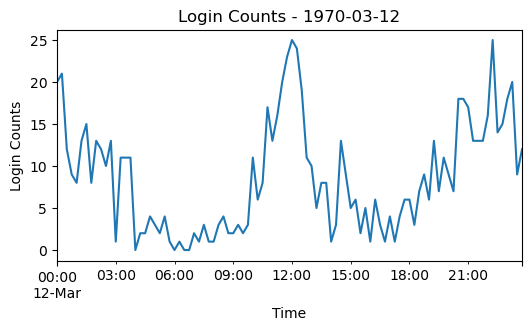

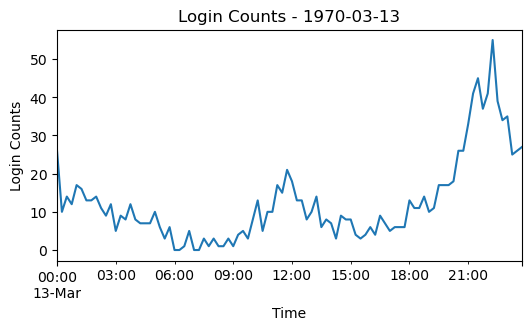

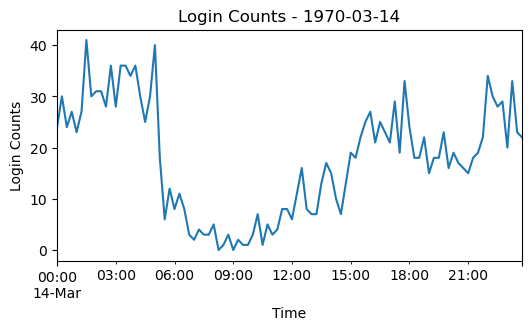

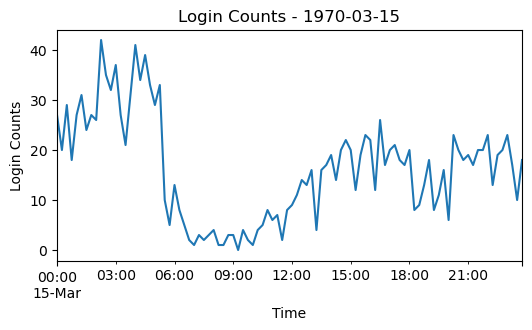

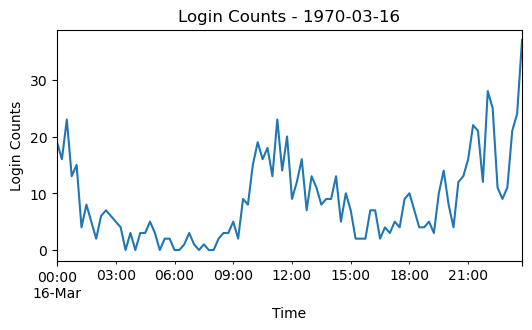

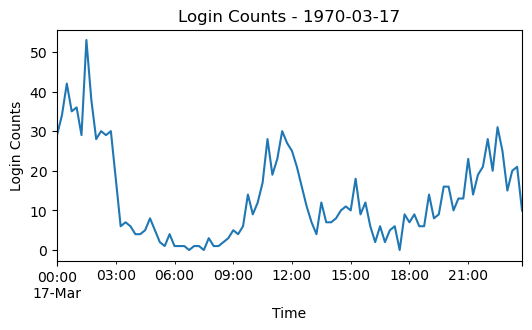

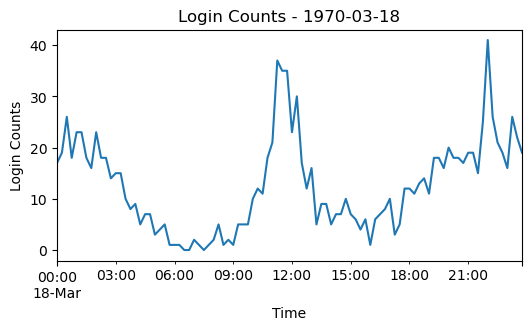

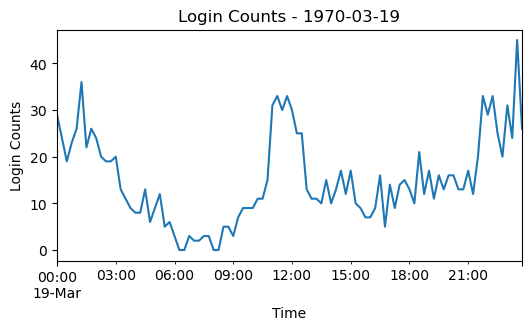

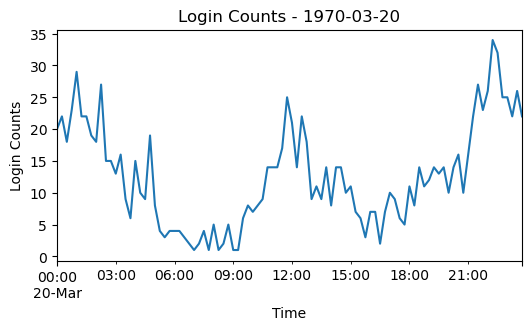

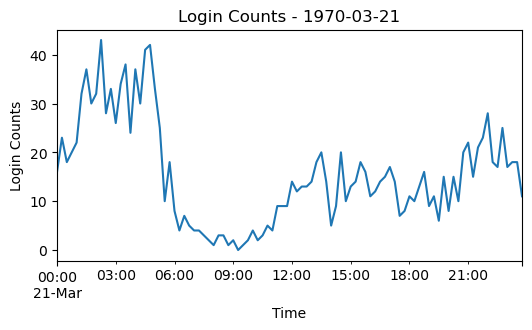

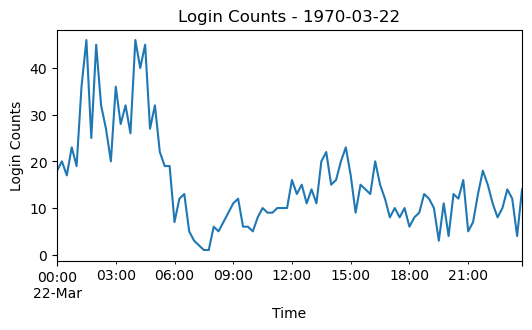

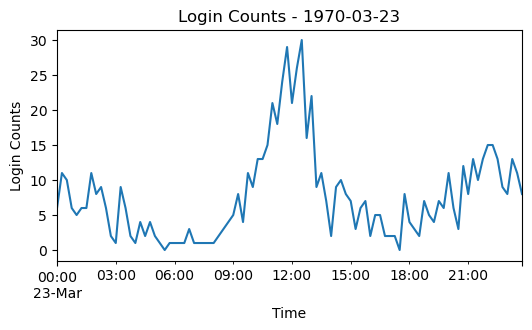

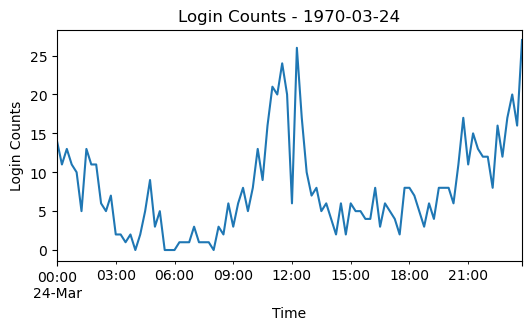

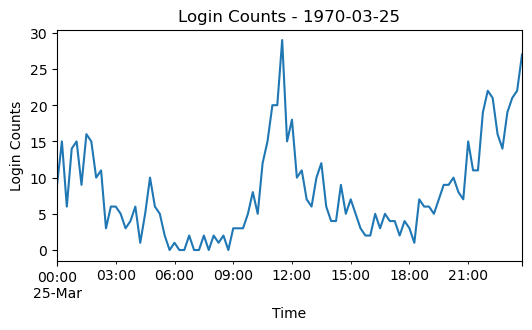

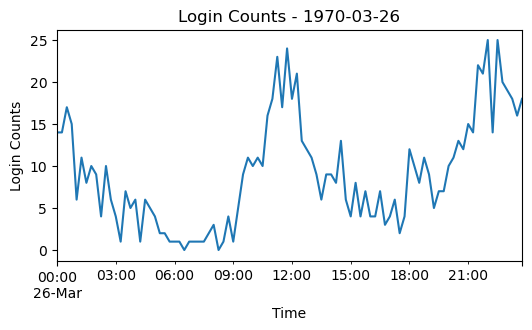

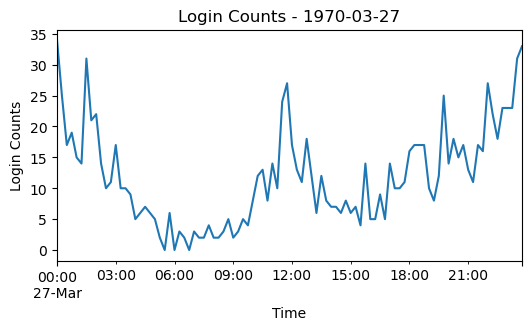

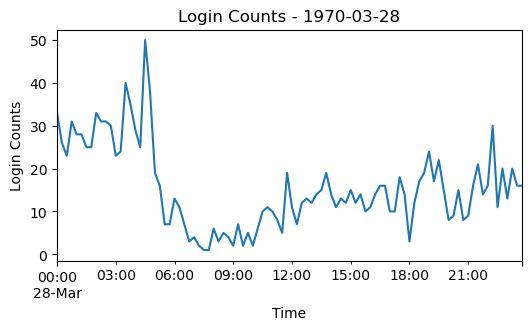

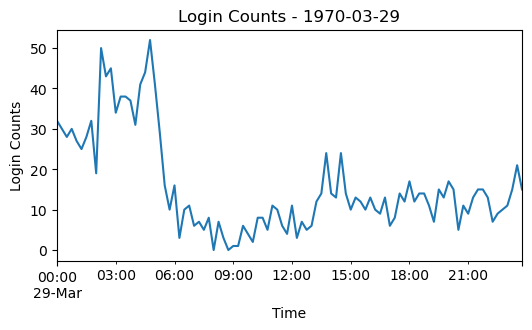

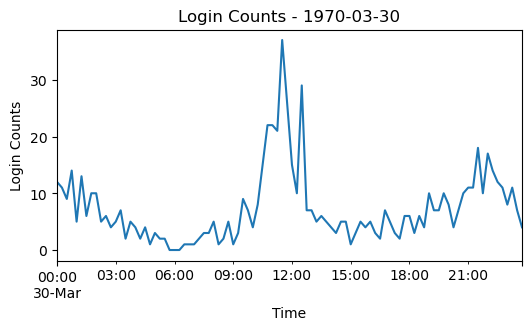

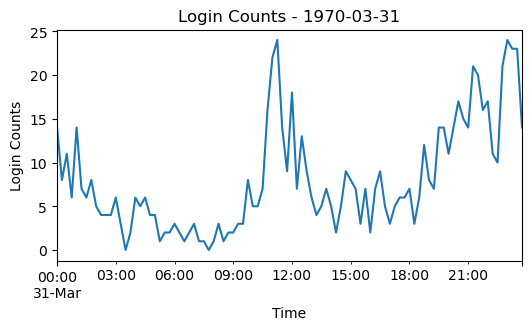

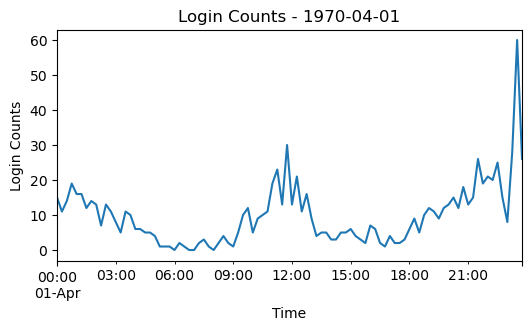

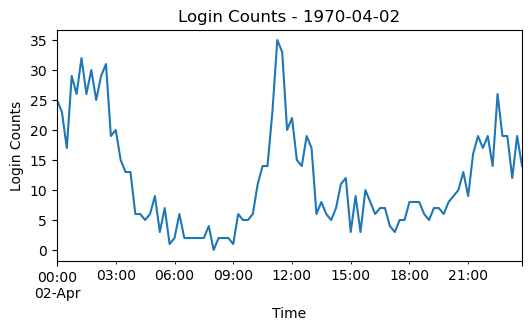

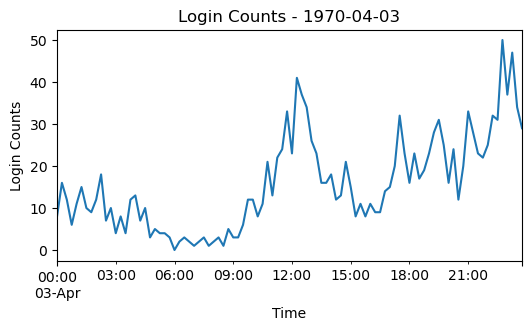

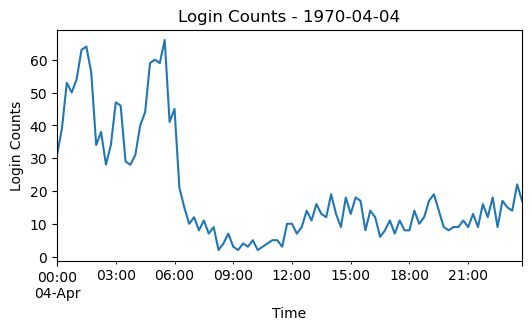

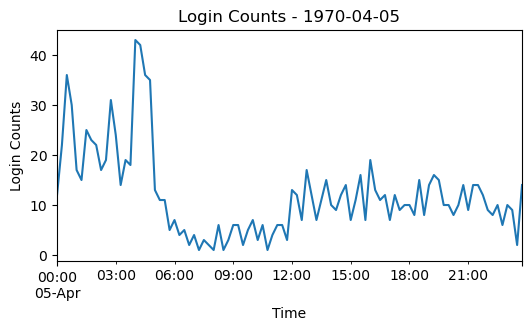

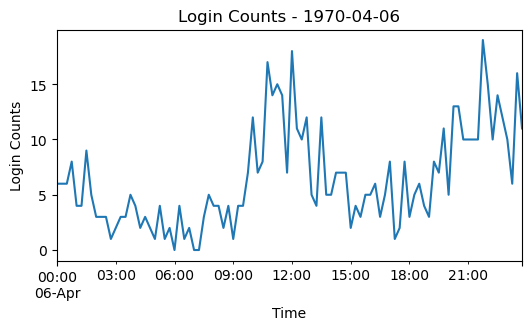

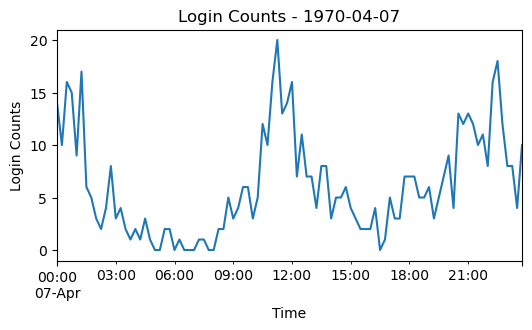

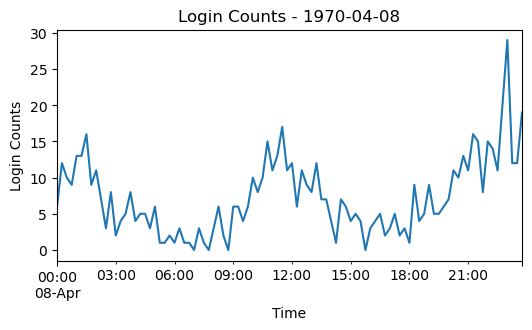

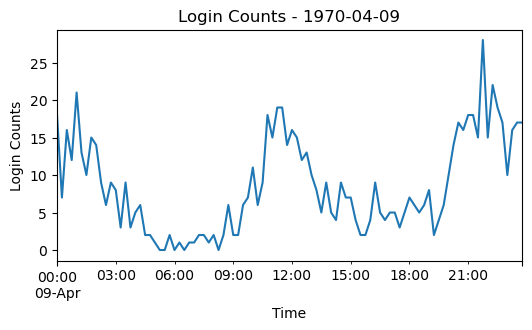

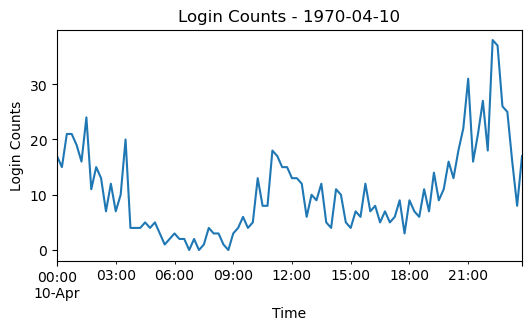

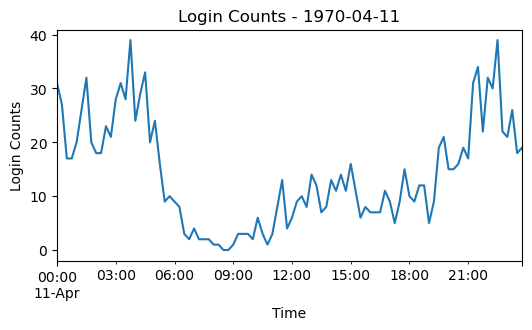

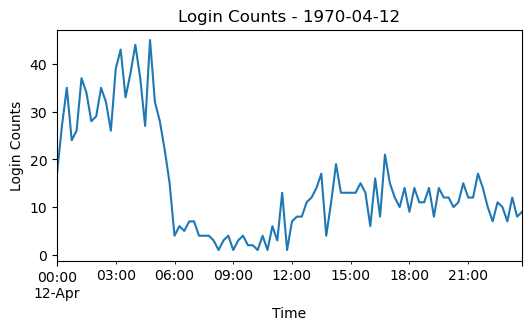

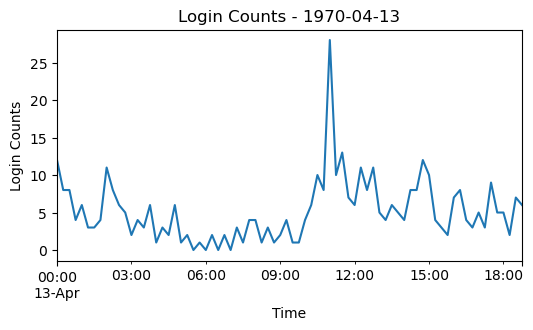

In [84]:
daily_login_counts2 = log_counts.resample('D').sum()

# Iterate through each day and create individual plots
for day in daily_login_counts2.index:
    # Extract data for the specific day
    day_data = log_counts[day.strftime('%Y-%m-%d')]
    
    # Plot the 15-minute interval counts
    plt.figure(figsize=(6, 3))
    day_data.plot()
    plt.title(f'Login Counts - {day.strftime("%Y-%m-%d")}')
    plt.xlabel('Time')
    plt.ylabel('Login Counts')
    plt.show()

It looks like there are local maximums near midday and at the end of a day--sometimes bleeding into the next morning. There's also local minimums in the mornings (6-9am) and afternoons (3-5pm).

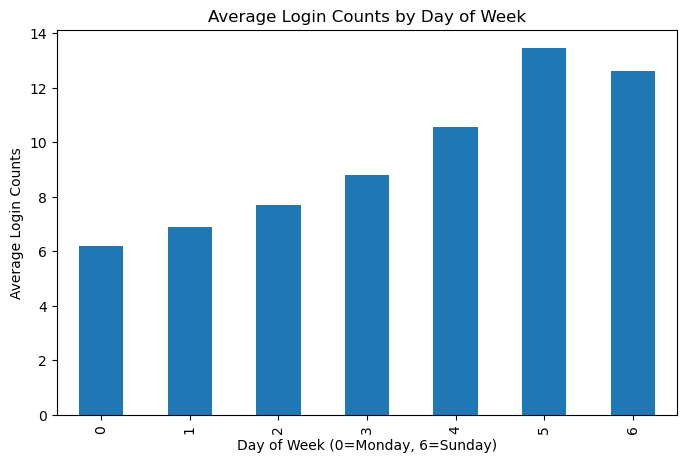

In [85]:
day_of_week = log_counts.index.dayofweek
login_counts_by_day = log_counts.groupby(day_of_week).mean()

# Plot day-of-week averages
plt.figure(figsize=(8, 5))
login_counts_by_day.plot(kind='bar')
plt.title('Average Login Counts by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Login Counts')
plt.show()

From here, we can see that people log in more and more as the week progresses with an average low on Mondays and an average high on Saturdays.

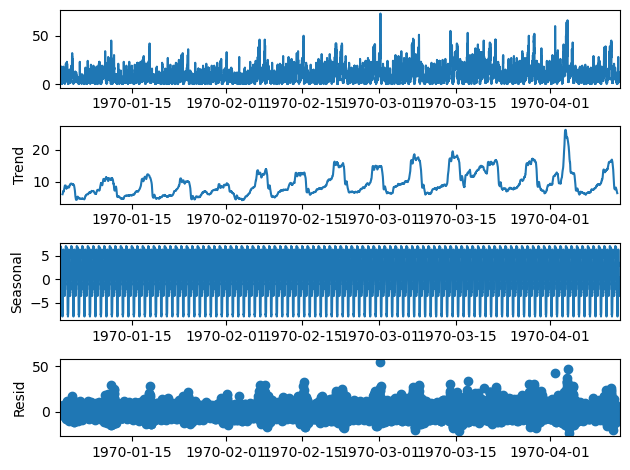

In [88]:
#Trying to decompose the time series 

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(log_counts, model='additive', period=96)  # Assuming 96 data points per day (15 minutes intervals)
result.plot()
plt.show()

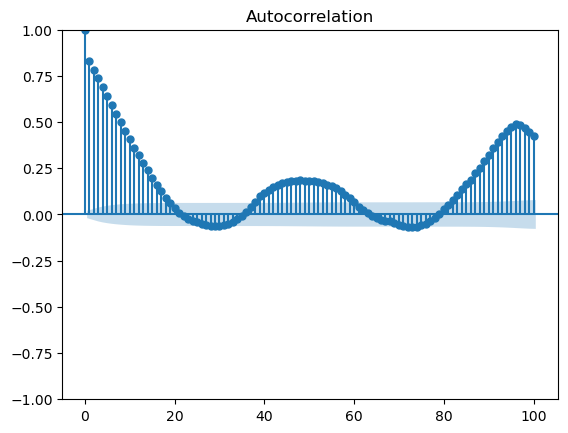

In [90]:
#Checking autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(log_counts, lags=100)
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(log_counts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -10.337954309060445
p-value: 2.732396654223006e-18


So this is a pretty stationary time series! 

# PART 2
Note: Gotham (G) active at night; Metropolis (M) active during day. If tolls were reimbursed as an experiment,

1)What would be a key measure of succes that showed driver partners serving both cities and why?

2)What would be the experiment? (How would you implement it? what statistical test would you conduct to verify significance? How would you interpet results and provide recommendations to the city operations team)

If I was trying to figure out whether or not reimbursing tolls encouraged driver partners to be available in both cities, I would track changes in total amount of toll numbers. Counting how many people enter and exit each city, particularly when one city is "asleep". Take for instance a driver partner that normally stays in G, inactive during the day, suddenly is making a trip over to the daylit busy M, the toll numbers would increase. If there were enough action going across both cities, then it would seem the experiement worked. I would choose this metric because it seems easy to count, and could be cross-referenced with license plates or credit card info to see whether or not the same driver partners are going back and forth between the cities.

To make the experiment, I would first need to have some baseline data to see what the current numbers are for toll numbers. Then I would introduce the reimbursment plan and as long as driver partners in both cities were aware of the changes, collect data on toll numbers. Perhaps I'd give each driver partner a "Good to Go" pass with their own special lane that doesn't require stopping. 

The null hypothesis would be that there was no significant difference before and after the implementation of the experiment. The alternative hypothesis is that there WOULD be significant increase in the toll numbers afetr the experiment. I would then find the p-value using a two-sample z-test and if it's less than 0.05, I could reject the null hypothesis.

If the p value is significant, I would recommend the toll reimbursment while keeping an eye out on the traffic increase.

# Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [26]:
df_info.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [93]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


It looks like there's almost 9000 missing values  for the avgerage rating of driver, under 400 missing values for phone, and about 200 missing values for average rating BY driver. To be honest though, those features don't seem that important to the study so I don't plan on doing anything regarding those rows.

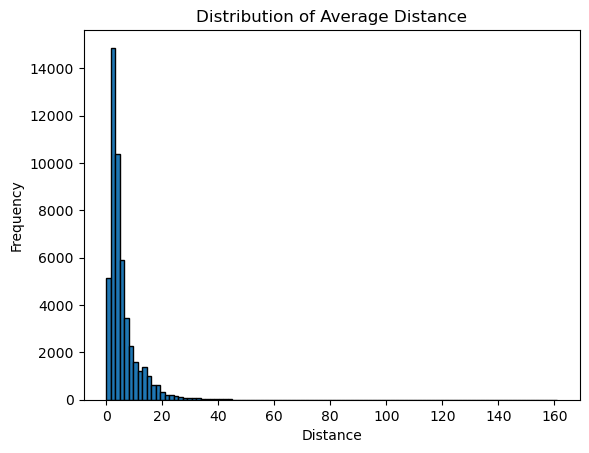

In [105]:
plt.hist(df_info['avg_dist'], bins=100, edgecolor='black')
plt.title('Distribution of Average Distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

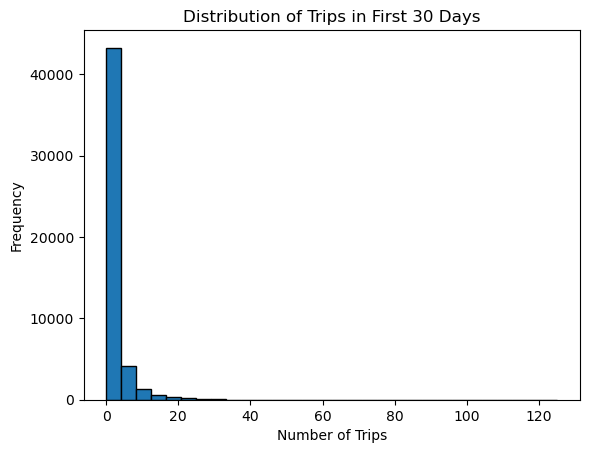

In [103]:
plt.hist(df_info['trips_in_first_30_days'], bins=30, edgecolor='black')
plt.title('Distribution of Trips in First 30 Days')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.show()

In [96]:
#Need to check retention...

df_info['last_trip_date'] = pd.to_datetime(df_info['last_trip_date'])
df_info['signup_date'] = pd.to_datetime(df_info['signup_date'])

# Calculate the date 30 days prior to the latest last_trip_date
cutoff_date = df_info['last_trip_date'].max() - pd.Timedelta('30 days')

# Create a binary column indicating whether a user is retained
df_info['retained'] = (df_info['last_trip_date'] > cutoff_date).astype(int)

In [97]:
fraction_retained = df_info['retained'].mean()
print(f'Fraction of retained users: {fraction_retained:.2%}')

Fraction of retained users: 36.62%


In [106]:
#If I'm going to use a Logistic Regression, I need to fill in my missing values

df_info['avg_rating_of_driver'].fillna(df_info['avg_rating_of_driver'].mean(), inplace=True)
df_info['avg_rating_by_driver'].fillna(df_info['avg_rating_by_driver'].mean(), inplace=True)

In [108]:
df_info['phone'].fillna(df_info['phone'].mode()[0], inplace=True)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Select features and target variable
features = df_info.drop(['retained', 'last_trip_date', 'signup_date'], axis=1)
target = df_info['retained']

# Convert categorical features to dummy variables
features = pd.get_dummies(features, columns=['city', 'phone', 'ultimate_black_user'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', classification_rep)

Accuracy: 71.98%
Confusion Matrix:
 [[5355  967]
 [1835 1843]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      6322
           1       0.66      0.50      0.57      3678

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



/Users/mattnelson/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This model is not the best for predicting retention. 66% of classified retained were correctly identified, but it only cuaght 50% of all the retained. Let's see what's going on with feature importance.

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)
model.fit(features_standardized, target)
feature_coefficients_standardized = model.coef_[0]

feature_importance_standardized_df = pd.DataFrame({'Feature': features.columns, 'Coefficient': feature_coefficients_standardized})
feature_importance_standardized_df['Absolute Coefficient'] = feature_importance_standardized_df['Coefficient'].abs()
feature_importance_standardized_df = feature_importance_standardized_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display standardized feature importance DataFrame
print(feature_importance_standardized_df)

                      Feature  Coefficient  Absolute Coefficient
0      trips_in_first_30_days     0.462779              0.462779
8         city_King's Landing     0.445296              0.445296
7                city_Astapor    -0.313820              0.313820
10              phone_Android    -0.261734              0.261734
11               phone_iPhone     0.261734              0.261734
12  ultimate_black_user_False    -0.217385              0.217385
13   ultimate_black_user_True     0.217385              0.217385
5                    avg_dist    -0.210473              0.210473
3                   surge_pct     0.082853              0.082853
6        avg_rating_by_driver    -0.071408              0.071408
9             city_Winterfell    -0.062822              0.062822
2                   avg_surge    -0.039018              0.039018
4                 weekday_pct     0.038296              0.038296
1        avg_rating_of_driver    -0.033049              0.033049


Since retention is based on a 30 day limit, it makes sense that an increase in the number of trips in the first 30 days would be correlated to an increased likelihood of retention. Interesting about King's Landing, but also intereseting is the negative correlation with Astapor and Android phones. Let's make another model.

In [111]:
from sklearn.ensemble import GradientBoostingClassifier


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb)

print(f'Gradient Boosting Accuracy: {accuracy_gb:.2%}')
print('Gradient Boosting Confusion Matrix:\n', conf_matrix_gb)
print('Gradient Boosting Classification Report:\n', classification_rep_gb)

Gradient Boosting Accuracy: 78.94%
Gradient Boosting Confusion Matrix:
 [[5431  891]
 [1215 2463]]
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      6322
           1       0.73      0.67      0.70      3678

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000



Let's try one more with slightly different parameters...

In [112]:
gb_model_tuned = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_model_tuned.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb_tuned = gb_model_tuned.predict(X_test)

# Evaluate the tuned Gradient Boosting model
accuracy_gb_tuned = accuracy_score(y_test, y_pred_gb_tuned)
conf_matrix_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)
classification_rep_gb_tuned = classification_report(y_test, y_pred_gb_tuned)

print(f'Tuned Gradient Boosting Accuracy: {accuracy_gb_tuned:.2%}')
print('Tuned Gradient Boosting Confusion Matrix:\n', conf_matrix_gb_tuned)
print('Tuned Gradient Boosting Classification Report:\n', classification_rep_gb_tuned)

Tuned Gradient Boosting Accuracy: 79.24%
Tuned Gradient Boosting Confusion Matrix:
 [[5436  886]
 [1190 2488]]
Tuned Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      6322
           1       0.74      0.68      0.71      3678

    accuracy                           0.79     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.79      0.79      0.79     10000



That's even better! Wohoo!

                      Feature  Importance
6        avg_rating_by_driver    0.233502
3                   surge_pct    0.187046
8         city_King's Landing    0.153784
4                 weekday_pct    0.148104
10              phone_Android    0.057708
12  ultimate_black_user_False    0.043996
0      trips_in_first_30_days    0.040240
11               phone_iPhone    0.034824
7                city_Astapor    0.029965
13   ultimate_black_user_True    0.026655
5                    avg_dist    0.021949
1        avg_rating_of_driver    0.014276
2                   avg_surge    0.006946
9             city_Winterfell    0.001005


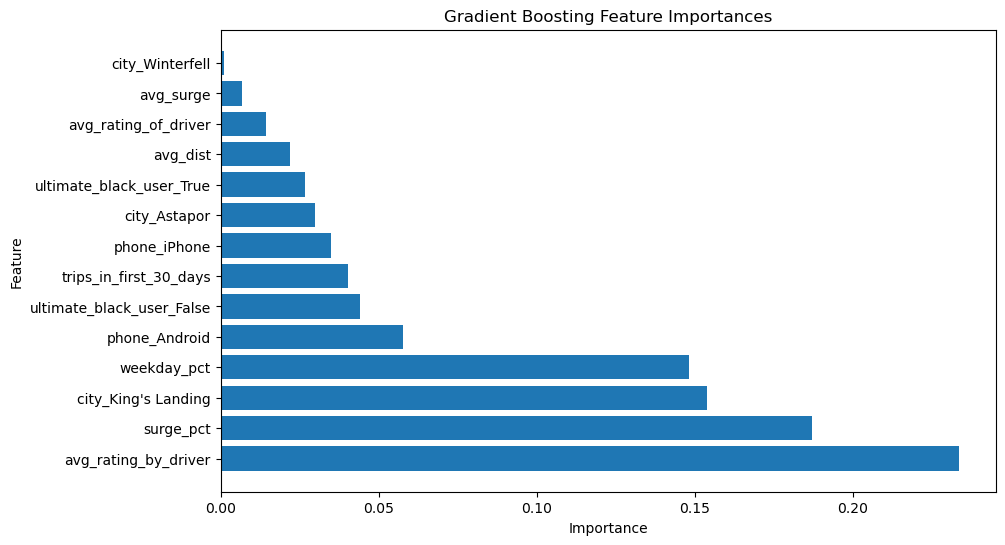

In [113]:
import numpy as np

feature_importances = gb_model_tuned.feature_importances_
feature_importance_df_gb = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance', ascending=False)
print(feature_importance_df_gb)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_gb['Feature'], feature_importance_df_gb['Importance'])
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

I feel like there are some intereseting points here about the features. The average rating by driver I think is interesting, because we don't know if it's a positive or negative correlation. Either "good" passengers or "bad" passengers take cars more. If there was an incentive for passengers over a certain rating, it might get more people to take car. 

The consistent feature from the other model is King's Landing. People there are really sticking around. Again, positive reenforcement coupled with city-vs-city comppetition. Offer King's Landing people a discount and then say that whichever city has the most pick ups next month gets another discount.

Finally, if someone is using the service on the weekday instead of on the weekend, it could mean that it's an important tool in their daily lives. Again, some sort of discount for the weekday use could get more people to ride 